In [1]:
from orion.data import load_signal, load_anomalies

# 1. Data

In [2]:
signal_name = 'multivariate/S-1'

data = load_signal(signal_name)
data = data[:10000]

data.head()

,timestamp,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,1222819200,-0.366359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1222840800,-0.394108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1222862400,0.403625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1222884000,-0.362759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1222905600,-0.370746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Pipeline

In [3]:
from mlblocks import MLPipeline

pipeline_name = 'chronos2'

pipeline = MLPipeline(pipeline_name)
    

/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-16 15:13:33.647160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-16 15:13:33.679684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-16 15:13:33.679717: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-16 15:13:33.679750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugi

### Hyperparameters

The Chronos2 pipeline can be customized with the following hyperparameters:

| Primitive | Parameter | Default | Description |
|-----------|-----------|---------|-------------|
| time_segments_aggregate | `interval` | 21600 | Aggregation interval in seconds |
| time_segments_aggregate | `method` | "mean" | Aggregation method (mean, median, sum) |
| rolling_window_sequences | `window_size` | 250 | Context window size |
| **Chronos2** | `pred_len` | 1 | Prediction horizon length |
| **Chronos2** | `batch_size` | 32 | Batch size for inference |
| **Chronos2** | `target` | 0 | Target column index (multivariate) |
| find_anomalies | `window_size_portion` | 0.33 | Portion of data for window |
| find_anomalies | `fixed_threshold` | True | Use fixed vs dynamic threshold |

In [4]:
hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "time_column": "timestamp",
        "interval": 21600,        
        "method": "mean"        
    },
    
    "mlstars.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        "target_column": 0,
        "window_size": 250
    },
    
    "orion.primitives.chronos2.Chronos2#1": {
        "pred_len": 1,          
        "batch_size": 32,       
        "target": 0,            
    },
    
    "orion.primitives.timeseries_anomalies.find_anomalies#1": {
        "window_size_portion": 0.33,
        "window_step_size_portion": 0.1,
        "fixed_threshold": True
    }
}

pipeline.set_hyperparameters(hyperparameters)

## step by step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its `primtivies` attribute. 

The `UniTS` contains 6 primitives. we will observe how the `context` (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [5]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'mlstars.custom.timeseries_preprocessing.rolling_window_sequences',
 'orion.primitives.chronos2.Chronos2',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    - `X` sequence of aggregated values, one column for each aggregation method.
    - `index` sequence of index values (first index of each aggregated segment).

In [6]:
context = pipeline.fit(data, output_=0)
context.keys()

dict_keys(['X', 'index'])

In [7]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.36635895  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
entry at 1222840800 has value [-0.39410778  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
entry at 1222862400 has value [0.4036246 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.       ]
entry at 1222884000 has value [-0.36275906  0.          0.          0.          0.          0.
  0.          0.          0.     

### SimpleImputer
this primitive is an imputation transformer for filling missing values.
* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a transformed version of X.

In [8]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

### rolling window sequence
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**: 
    - `X` n-dimensional sequence to iterate over.
    - `index` array containing the index values of X.
* **output**:
    - `X` input sequences.
    - `y` target sequences.
    - `index` first index value of each input sequence.
    - `target_index` first index value of each target sequence.

In [9]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X', 'y', 'target_index'])

In [10]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)

print("X shape = {}\ny shape = {}\nindex shape = {}\ntarget index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['target_index'].shape))

X shape = (9750, 250, 25)
y shape = (9750, 1)
index shape = (9750,)
target index shape = (9750,)


### Chronos-2
This is the forecasting step using Amazon Chronos-2 Time Series Foundation Model. You can read more about it in the [related paper](https://arxiv.org/abs/2510.15821). The [Huggingface Repo](https://huggingface.co/amazon/chronos-2) has additional helpful information about the use of the model. This is a multivariate model that does single target predictions.

* **input**: 
    - `X` n-dimensional array containing the input sequences for the model.
* **output**: 
    - `y_hat` predicted values for target column

In [11]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'X', 'y', 'y_hat'])

In [12]:
context['y_hat'].shape

(9750, 1)

### regression errors

this primitive computes an array of errors comparing predictions and expected output.

* **input**: 
    - `y` ground truth.
    - `y_hat` forecasted values.
* **output**: `errors` array of errors.

In [13]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'y_hat', 'X', 'y', 'errors'])

### find anomalies

this primitive finds anomalies from sequence of errors

* **input**: 
    - `errors` array of errors
    - `target_index` indices
* **output**: `anomalies`.

In [14]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [15]:
context['anomalies']

array([[1.22821920e+09, 1.22945040e+09, 9.14337515e-01],
       [1.40380560e+09, 1.40596560e+09, 2.28091527e-03]])

## 3. Evaluate performance

In this next step we will load some already known anomalous intervals and evaluate how
good our anomaly detection was by comparing those with our detected intervals.

For this, we will first load the known anomalies for the signal that we are using:

In [16]:
from orion.data import load_anomalies

ground_truth = load_anomalies('S-1')
ground_truth

,start,end
0,1398168000,1407823200


In [17]:
anomalies = []
for ano in context['anomalies']:
    anomalies.append((ano[0], ano[1]))
anomalies

[(1228219200.0, 1229450400.0), (1403805600.0, 1405965600.0)]

In [18]:
from orion.evaluation import contextual_confusion_matrix, contextual_f1_score

start, end = context['index'][0], context['index'][-1]

contextual_confusion_matrix(ground_truth, anomalies, start = start, end = end, weighted=False)

(None, 1, 0, 1)

In [19]:
contextual_f1_score(ground_truth, anomalies, start = start, end = end, weighted=False)

0.6666666666666666

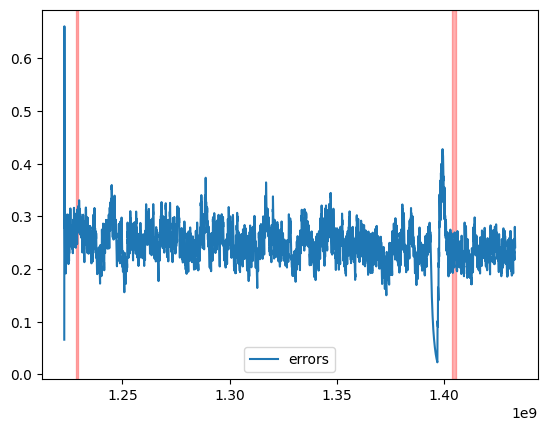

In [24]:
import matplotlib.pyplot as plt
plt.plot(context['index'], context['errors'], label='errors')
for anomaly in context['anomalies']:
    plt.axvspan(anomaly[0], anomaly[1], color='red', alpha=0.3)
plt.legend()
plt.show()